# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

## Here we perform clustering experiements

In [1]:
import numpy as np
import mne, os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import matplotlib.image as mpimg
import nimfa
from sklearn.cluster import KMeans


In [2]:
channel_picks               = ['O','T','P']
file_path = 'preprocessed/preprocessed_P1-epo.fif'
def load_epochs(file_path,all_epochs = []):
    epochs = mne.read_epochs(file_path, preload=False)
    return epochs
epochs = load_epochs(file_path)

Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items activated


In [3]:
epochs.metadata

,trial_type,image_nr,category_nr,exemplar_nr,test_image_nr,things_category_nr,things_image_nr,things_exemplar_nr,image_path,onset,image_on,image_off,responded,key_id,key_time,RT,session_nr,run_nr
0,exp,21118,1760,10,NaN,1760.0,24812.0,10.0,images_meg/vest/vest_10s.jpg,3.00,3.005025,3.505181,0,NaN,NaN,NaN,1,1
1,exp,6922,577,10,NaN,577.0,8355.0,10.0,images_meg/fencepost/fencepost_10s.jpg,4.65,4.655683,5.155901,0,NaN,NaN,NaN,1,1
2,exp,7522,627,10,NaN,627.0,9054.0,10.0,images_meg/fondue/fondue_10s.jpg,6.00,6.206278,6.706482,0,NaN,NaN,NaN,1,1
3,exp,2950,246,10,NaN,246.0,3648.0,10.0,images_meg/camel/camel_10s.jpg,7.50,7.556825,8.056974,0,NaN,NaN,NaN,1,1
4,exp,18682,1557,10,NaN,1557.0,21998.0,10.0,images_meg/stingray/stingray_10s.jpg,9.00,9.074120,9.574357,0,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,exp,303,26,3,NaN,26.0,358.0,3.0,images_meg/anteater/anteater_03s.jpg,333.25,333.331516,333.831749,0,NaN,NaN,NaN,12,10
27044,exp,1671,140,3,NaN,140.0,2131.0,3.0,images_meg/blimp/blimp_03n.jpg,334.65,334.832104,335.332262,0,NaN,NaN,NaN,12,10
27045,exp,16083,1341,3,NaN,1341.0,19070.0,3.0,images_meg/rug/rug_03s.jpg,336.00,336.215922,336.716176,0,NaN,NaN,NaN,12,10
27046,exp,4731,395,3,NaN,395.0,5680.0,3.0,images_meg/computer/computer_03n.jpg,337.60,337.599834,338.100026,0,NaN,NaN,NaN,12,10


In [4]:
name = channel_picks[0]
print(name, channel_picks)
# ctf_layout = mne.find_layout(epochs.info)
picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
ep1 = epochs[epochs.metadata['trial_type']=='exp']  
ep1.load_data() 
ep1.pick_channels(ch_names=picks_epochs); # supress output


O ['O', 'T', 'P']
Loading data for 22248 events and 281 original time points ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [5]:
NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_CHANNELS_OPT = 39
NOS_TIME_POINTS = 281
time_points = epochs.times 

In [6]:
# Load concept epochs if they already exist
if os.path.exists('concept_epochs.npy'):
    concept_epochs = np.load('concept_epochs.npy')
else:
    # Initialize the concept_epochs array with zeros
    concept_epochs = np.zeros((NOS_IMAGE_PER_CONCEPT, NOS_CONCEPTS, NOS_TIME_POINTS, NOS_CHANNELS_OPT))
    
    # Extract all data matching the condition in one go
    indices = ep1.metadata['category_nr'].values - 1  # Adjust index (assuming category_nr starts at 1)
    concept_epochs[:, indices, :, :] = ep1._data.transpose(0, 2, 1)
    
    # Save the array
    np.save('concept_epochs.npy', concept_epochs)

In [7]:
concept_epochs.shape

(12, 1854, 281, 39)

In [9]:
average_concept_epochs = concept_epochs.mean(axis = 0)
average_concept_epochs.shape

(1854, 281, 39)

In [10]:
# # z_scored_epochs = np.zeros_like(average_concept_epochs)
# for channel in range(NOS_CHANNELS_OPT):
#     mean = average_concept_epochs[:,channel,:].mean()
#     stdev = average_concept_epochs[:,channel,:].std()
#     average_concept_epochs[:,channel,:] = (average_concept_epochs[:,channel,:] - mean) / stdev

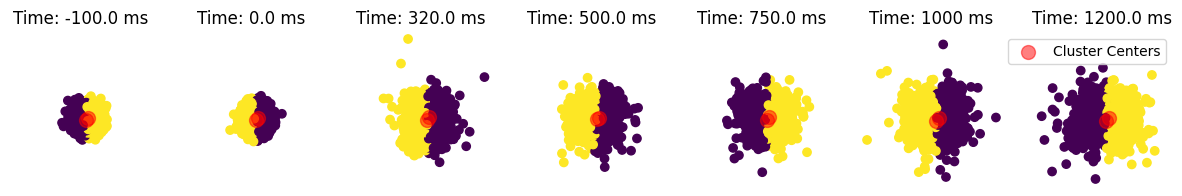

In [ ]:
times = [-0.1,0.0, 0.320, 0.5, 0.75, 1, 1.2]
f, axes = plt.subplots(1, len(times), sharex=True, sharey = True, figsize=(15, 2))   
for i,t in enumerate(times):
    index = epochs.times == t
    data = average_concept_epochs[:, index, :].squeeze() 
    # print(data.shape)
    kmeans = KMeans(n_clusters=2).fit(data)
    labels = kmeans.labels_
    # Get cluster centers
    centers = kmeans.cluster_centers_  # Shape: (2, 39)

    # Example Output
    # print("Labels Shape:", labels.shape)  # (1854,)
    # print("Cluster Centers Shape:", centers.shape)  # (2, 39)

    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
s
    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    # print(data_2d.shape)  
    axes[i].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
    axes[i].scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5, label='Cluster Centers')
    axes[i].set_title(f"Time: {t*1000} ms")
    axes[i].axis('off')
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm
times = [-0.1,0.0, 0.320, 0.5, 0.75, 1, 1.2]
f, axes = plt.subplots(1, len(times), sharex=True, sharey = True, figsize=(15, 2))   

for i,t in tqdm(enumerate(times)):
    index = epochs.times == t
    data = average_concept_epochs[:, index, :].squeeze() 
    # print(data.shape)
    kmeans = KMeans(n_clusters=2).fit(data)
    labels = kmeans.labels_
    # Get cluster centers
    centers = kmeans.cluster_centers_  # Shape: (2, 39)

    # Example Output
    # print("Labels Shape:", labels.shape)  # (1854,)
    # print("Cluster Centers Shape:", centers.shape)  # (2, 39)

    # from sklearn.decomposition import PCA
    # import matplotlib.pyplot as plt

    # Reduce to 2D for visualization
    # pca = PCA(n_components=2)
    # data_2d = pca.fit_transform(data)
    # print(data_2d.shape)  
    # Scatter plot
    

    # axes[i].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
    # axes[i].scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
    # axes[i].set_title(f"Time: {t*1000} ms")


    index_0 = np.where(labels == 0)[0]
    index_1 = np.where(labels == 1)[0]
    names_0 = []
    names_1 = []
    category27 = pd.read_csv('category27_manual.tsv', sep='\t')


    # print("cluster 0")
    for index in index_0:
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == index+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        names_0.append(image_paths.iloc[0].split('/')[-2])

    # print("cluster 1")
    for index in index_1:
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == index+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        names_1.append(image_paths.iloc[0].split('/')[-2])

    # how much percent of np.where(category27['animal'] == 1)[0] is in index_0

    print("At time ", t*1000, "ms")
    category_name = 'animal'
    category = np.where(category27[category_name] == 1)[0]
    category_0 = len(np.intersect1d(category, index_0))
    category_1 = len(np.intersect1d(category, index_1))
    print(f"division of category: {category_0} vs {category_1}") 
    # plot these divisions are bar plot
    axes[i].bar(['Cluster 0', 'Cluster 1'], [category_0, category_1])
    axes[i].set_title(f"Time: {t*1000} ms") 
    axes[0].set_ylabel(f'Number of images {category_name}')
    axes[i].set_xlabel('Cluster')
plt.show()
    


7it [00:00, 14.16it/s][00:00<?, ?it/s]


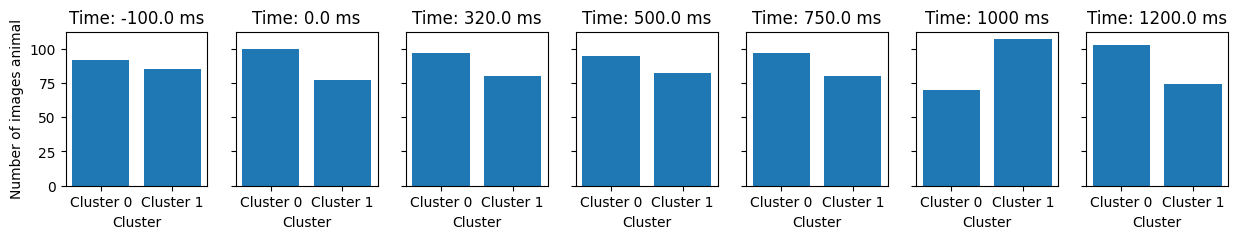

7it [00:00, 16.64it/s][00:00<00:23,  1.13it/s]


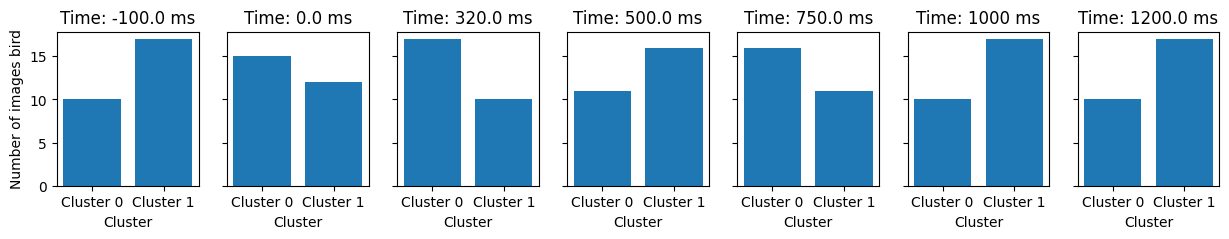

7it [00:00, 17.46it/s][00:01<00:19,  1.29it/s]


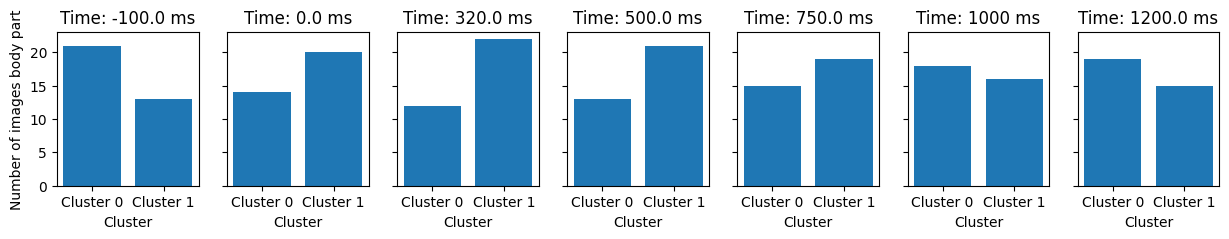

7it [00:00, 15.84it/s][00:02<00:17,  1.36it/s]


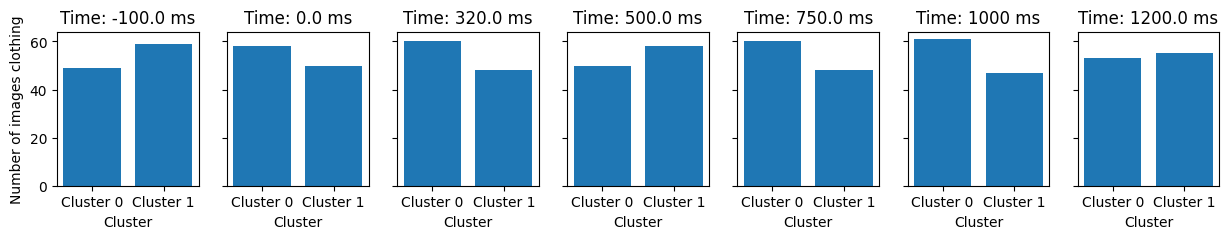

7it [00:00, 16.77it/s][00:03<00:16,  1.36it/s]


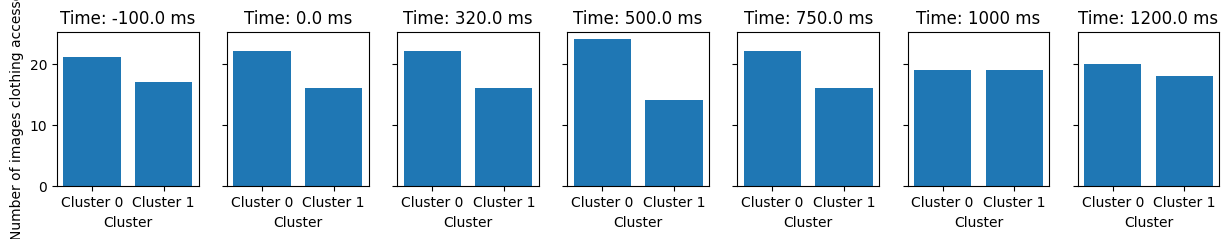

7it [00:00, 19.21it/s][00:03<00:15,  1.39it/s]


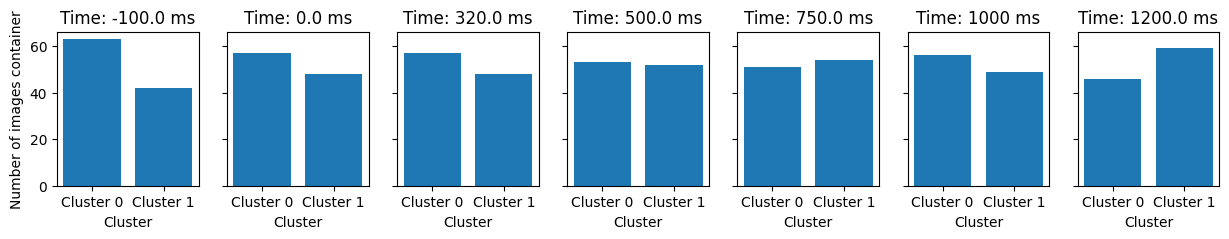

7it [00:00, 17.82it/s][00:04<00:15,  1.37it/s]


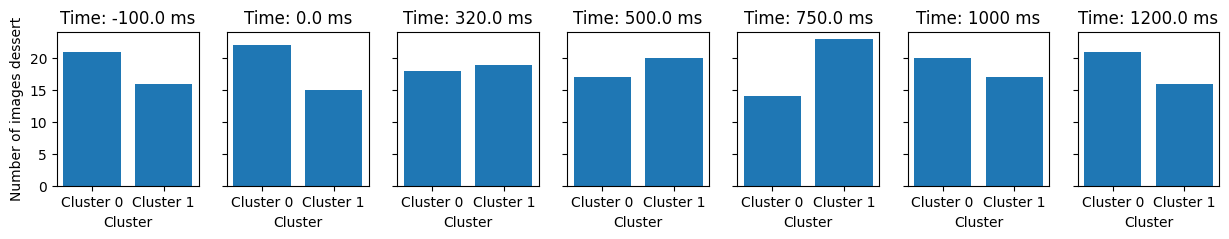

7it [00:00, 18.43it/s][00:05<00:14,  1.34it/s]


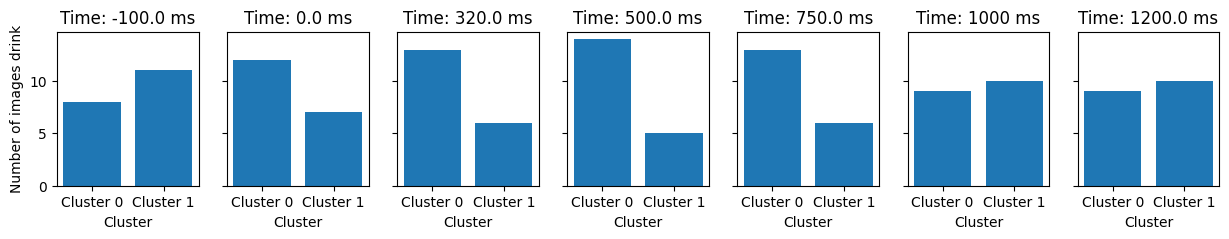

7it [00:00, 17.30it/s][00:05<00:13,  1.40it/s]


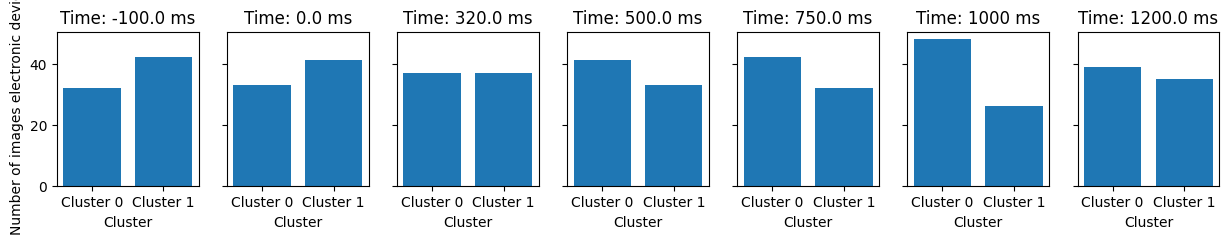

7it [00:00, 17.52it/s][00:06<00:13,  1.36it/s]


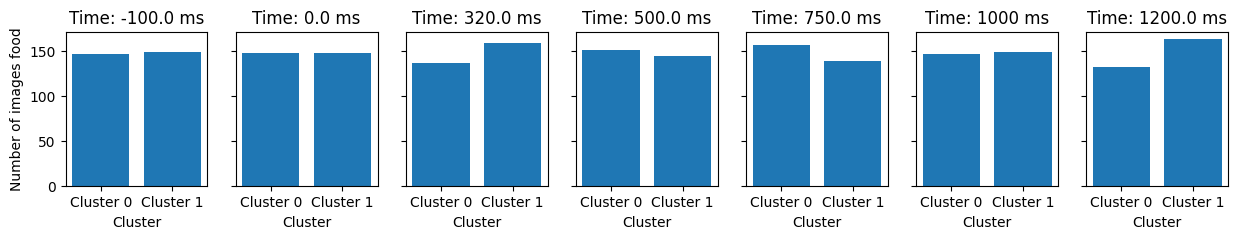

7it [00:00, 18.94it/s] [00:07<00:14,  1.18it/s]


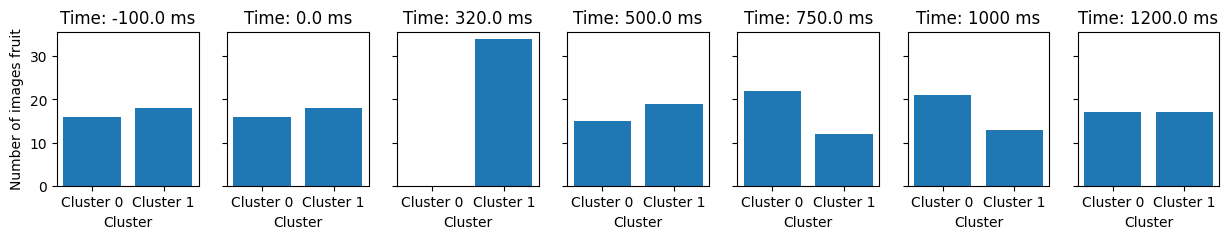

7it [00:00, 17.37it/s] [00:08<00:12,  1.27it/s]


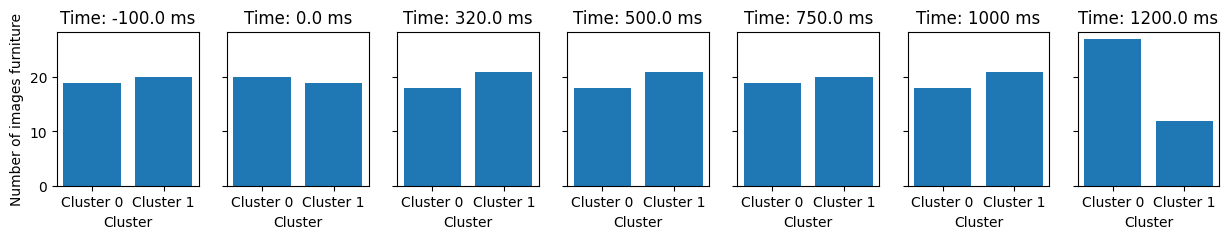

7it [00:00, 16.25it/s] [00:09<00:11,  1.27it/s]


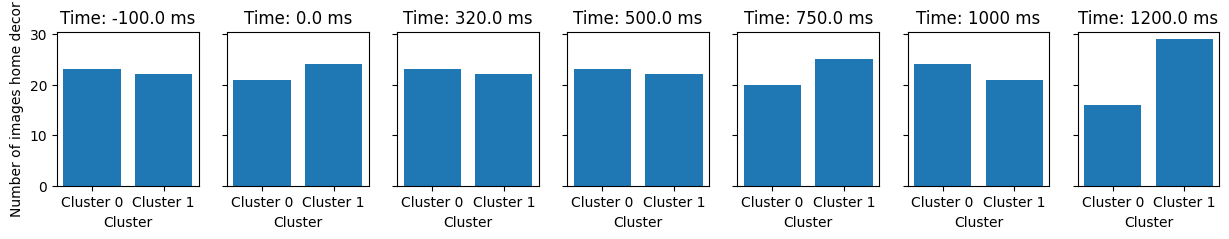

7it [00:00, 18.34it/s] [00:09<00:10,  1.31it/s]


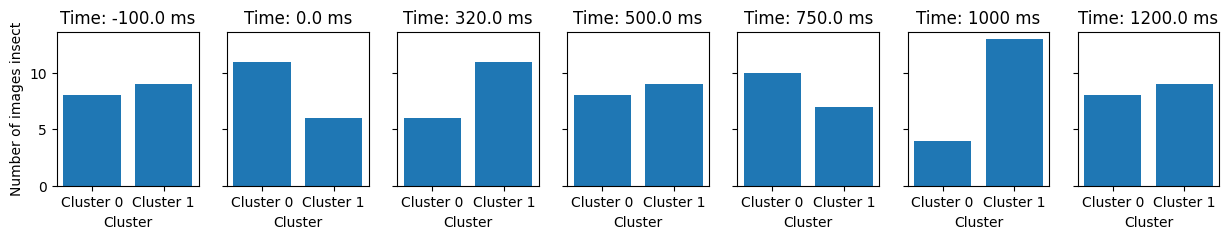

7it [00:00, 16.38it/s] [00:10<00:09,  1.37it/s]


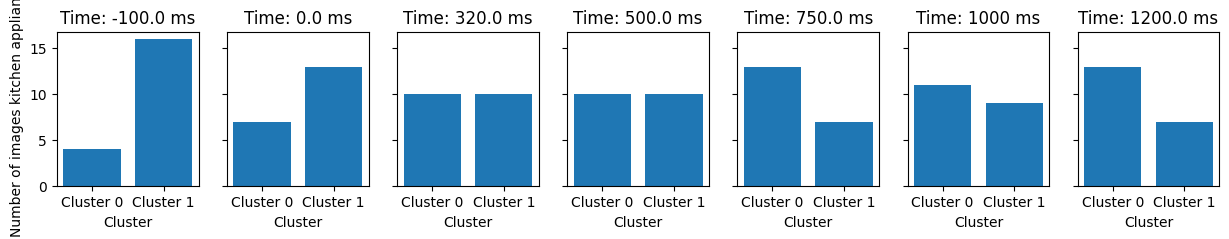

7it [00:00, 16.77it/s] [00:11<00:09,  1.32it/s]


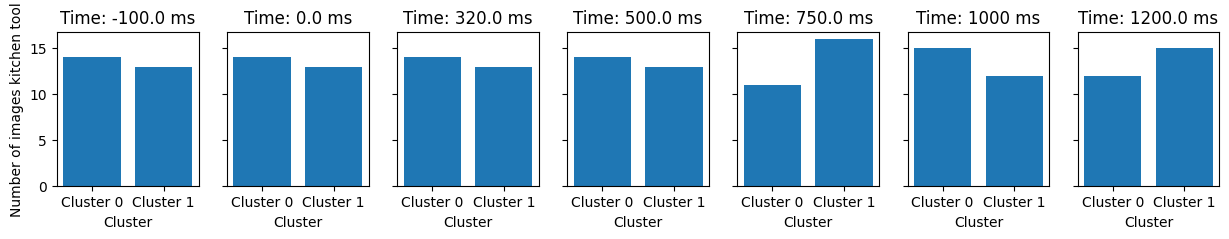

7it [00:00, 17.89it/s] [00:12<00:08,  1.36it/s]


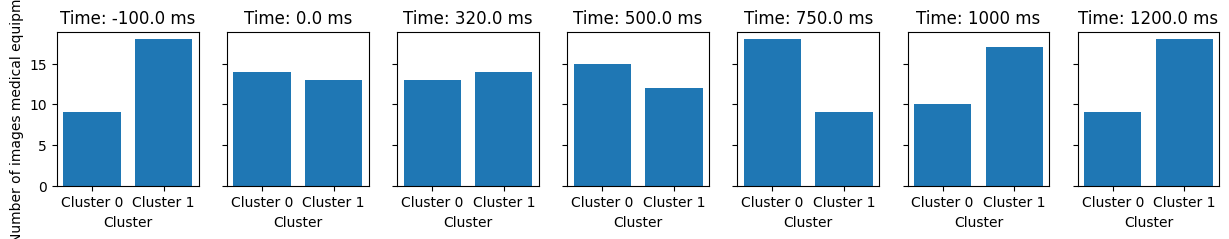

7it [00:00, 17.65it/s] [00:12<00:07,  1.38it/s]


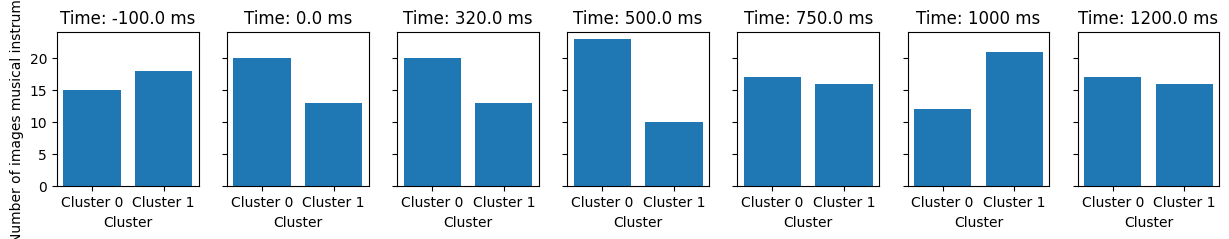

7it [00:00, 16.12it/s] [00:13<00:06,  1.40it/s]


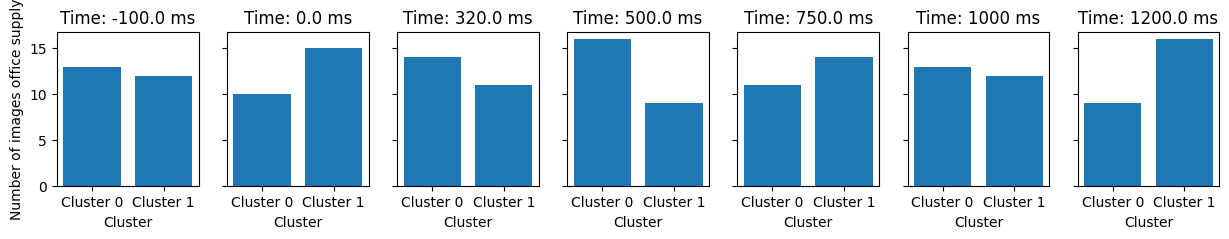

7it [00:00, 17.09it/s] [00:14<00:06,  1.20it/s]


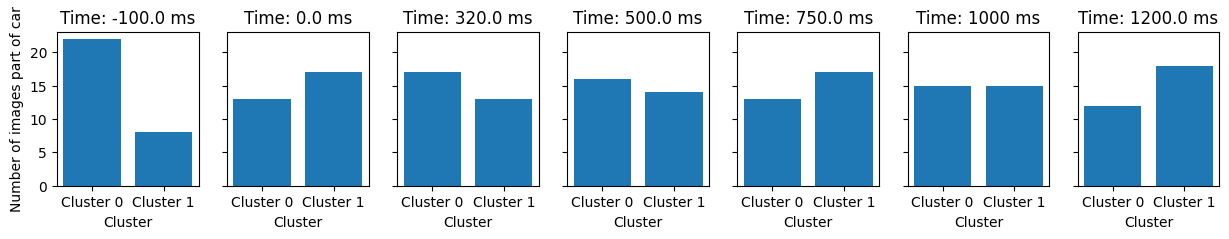

7it [00:00, 16.88it/s] [00:15<00:05,  1.25it/s]


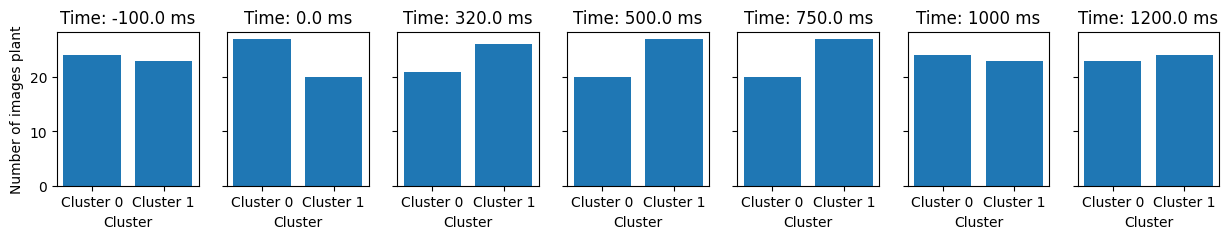

7it [00:00, 18.50it/s] [00:16<00:04,  1.29it/s]


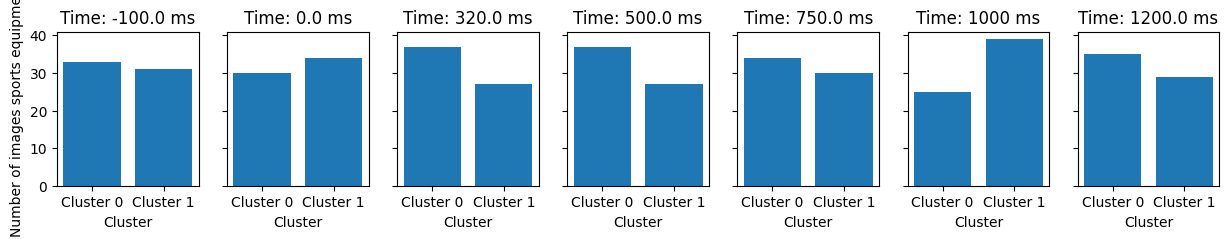

7it [00:00, 19.99it/s] [00:16<00:03,  1.34it/s]


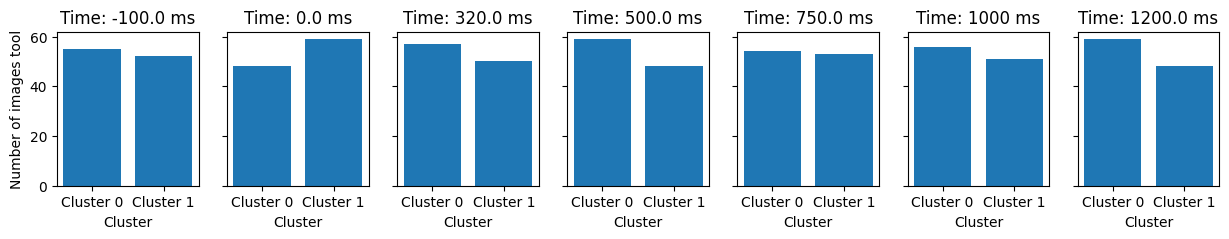

7it [00:00, 19.24it/s] [00:17<00:02,  1.40it/s]


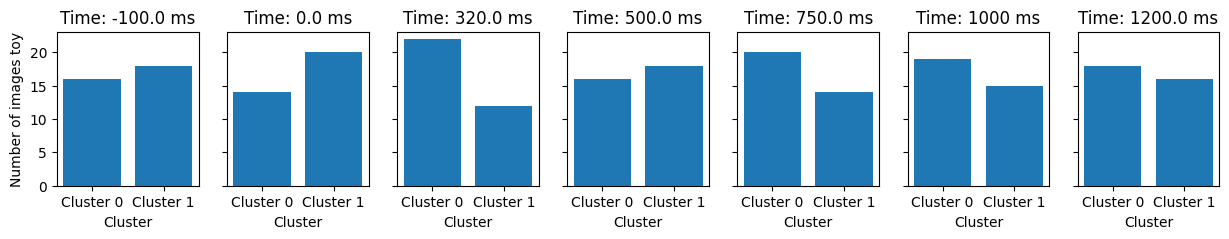

7it [00:00, 18.80it/s] [00:17<00:02,  1.45it/s]


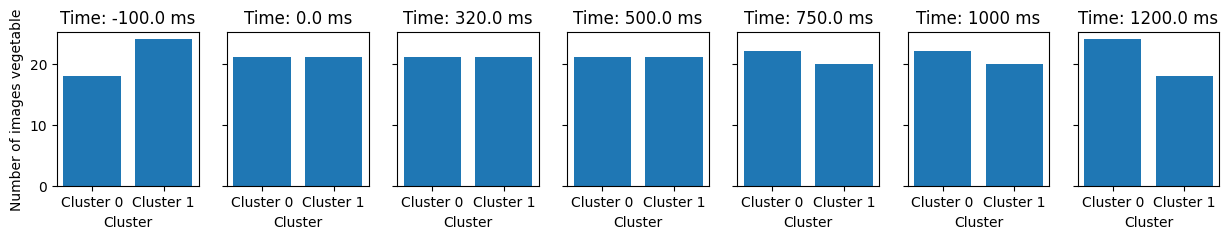

7it [00:00, 17.70it/s] [00:18<00:01,  1.48it/s]


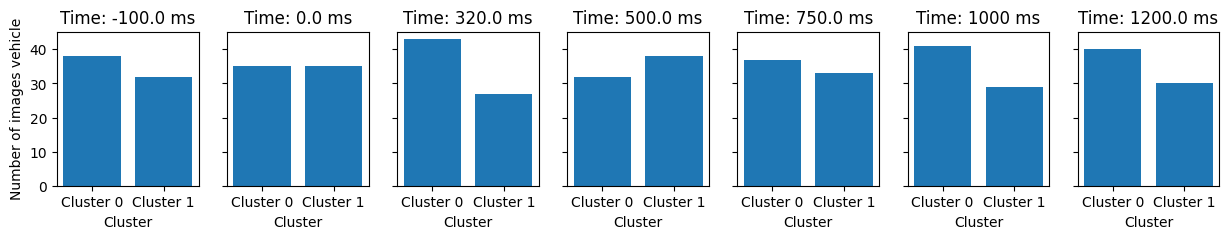

7it [00:00, 16.87it/s] [00:19<00:00,  1.47it/s]


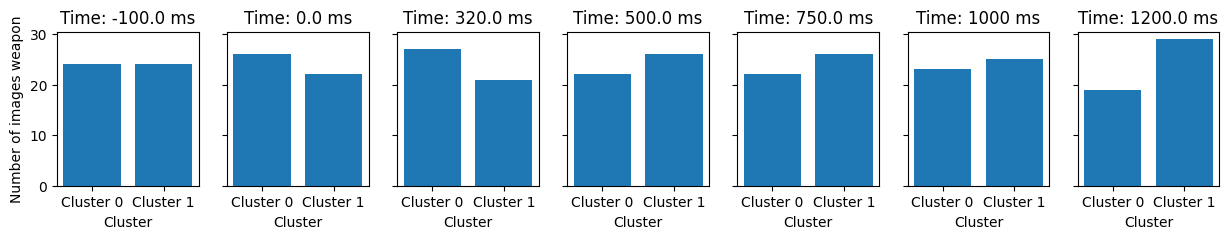

100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


In [44]:
from tqdm import tqdm
category27 = pd.read_csv('category27_manual.tsv', sep='\t')
for category_name in tqdm(category27.columns):
    times = [-0.1,0.0, 0.320, 0.5, 0.75, 1, 1.2]
    # category_name = 'animal'
    f, axes = plt.subplots(1, len(times), sharex=True, sharey = True, figsize=(15, 2))   

    for i,t in tqdm(enumerate(times)):
        index = epochs.times == t
        data = average_concept_epochs[:, index, :].squeeze() 
        # print(data.shape)
        kmeans = KMeans(n_clusters=2).fit(data)
        labels = kmeans.labels_
        # Get cluster centers
        centers = kmeans.cluster_centers_  # Shape: (2, 39)
        index_0 = np.where(labels == 0)[0]
        index_1 = np.where(labels == 1)[0]
        names_0 = []
        names_1 = []

        category = np.where(category27[category_name] == 1)[0]
        category_0 = len(np.intersect1d(category, index_0))
        category_1 = len(np.intersect1d(category, index_1))
        # print(f"division of category: {category_0} vs {category_1}") 
        # plot these divisions are bar plot
        axes[i].bar(['Cluster 0', 'Cluster 1'], [category_0, category_1])
        axes[i].set_title(f"Time: {t*1000} ms") 
        axes[0].set_ylabel(f'Number of images {category_name}')
        axes[i].set_xlabel('Cluster')
    plt.show()

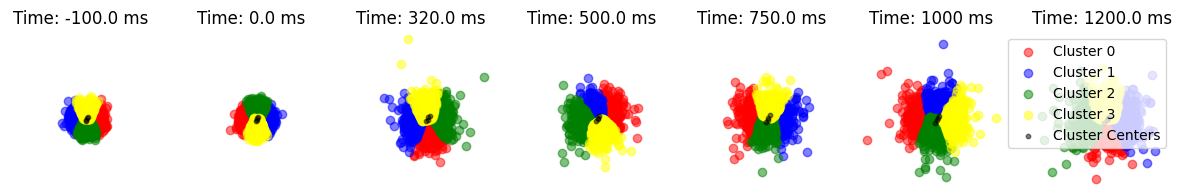

In [22]:
times = [-0.1,0.0, 0.320, 0.5, 0.75, 1, 1.2]
f, axes = plt.subplots(1, len(times), sharex=True, sharey = True, figsize=(15, 2))   
for i,t in enumerate(times):
    index = epochs.times == t
    data = average_concept_epochs[:, index, :].squeeze() 
    # print(data.shape)
    kmeans = KMeans(n_clusters=4).fit(data)
    labels = kmeans.labels_
    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    index_0 = np.where(labels == 0)[0]
    index_1 = np.where(labels == 1)[0]
    index_2 = np.where(labels == 2)[0]
    index_3 = np.where(labels == 3)[0]

    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    axes[i].scatter(data_2d[index_0, 0], data_2d[index_0, 1], c='red', label='Cluster 0', alpha=0.5)
    axes[i].scatter(data_2d[index_1, 0], data_2d[index_1, 1], c='blue', label='Cluster 1', alpha=0.5)  
    axes[i].scatter(data_2d[index_2, 0], data_2d[index_2, 1], c='green', label='Cluster 2', alpha=0.5)
    axes[i].scatter(data_2d[index_3, 0], data_2d[index_3, 1], c='yellow', label='Cluster 3', alpha=0.5)
    axes[i].scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5, label='Cluster Centers')
    axes[i].set_title(f"Time: {t*1000} ms")
    axes[i].axis('off')
plt.legend()        
plt.show()

  0%|          | 0/27 [00:00<?, ?it/s]

7it [00:00, 12.71it/s]


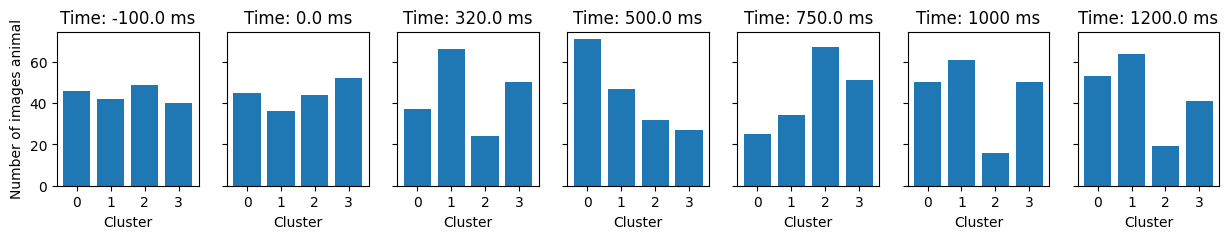

7it [00:00, 10.35it/s][00:01<00:39,  1.52s/it]


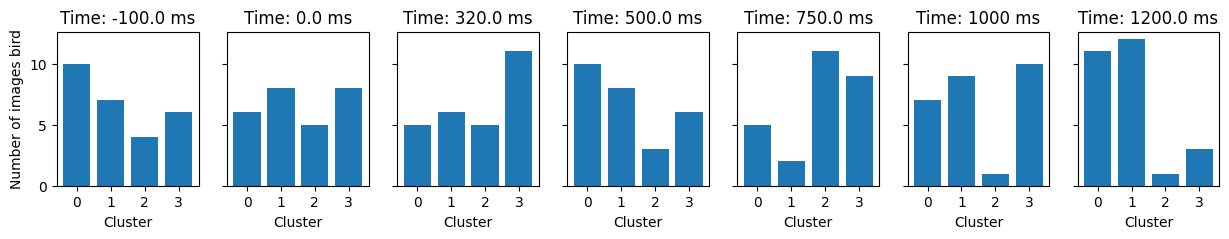

7it [00:00, 16.28it/s][00:02<00:32,  1.29s/it]


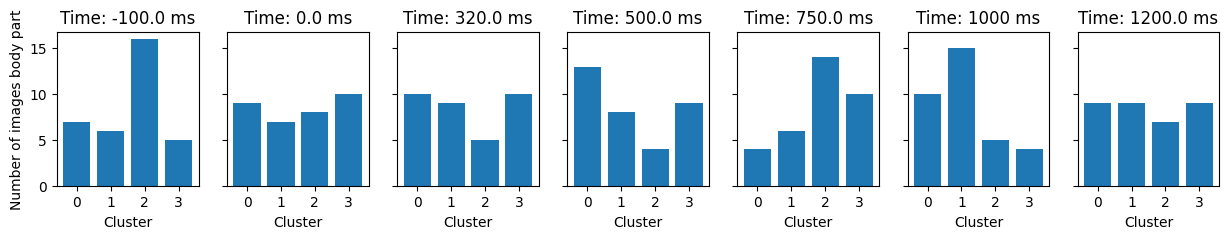

7it [00:00, 18.02it/s][00:03<00:24,  1.03s/it]


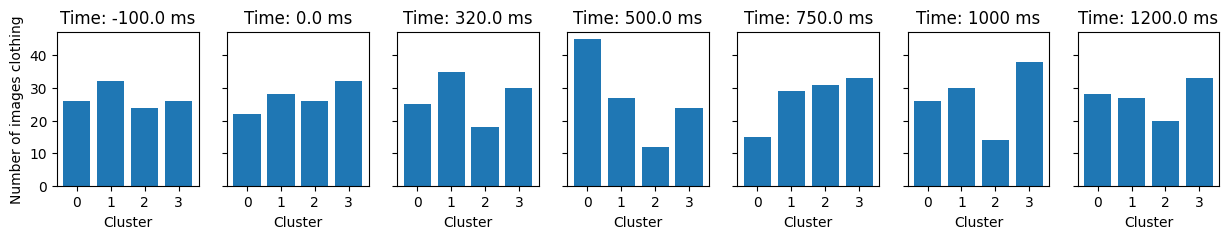

7it [00:00, 16.43it/s][00:04<00:20,  1.11it/s]


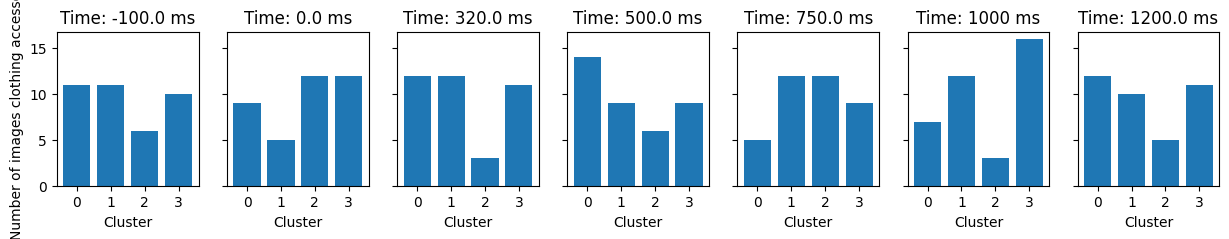

7it [00:00, 16.44it/s][00:04<00:18,  1.19it/s]


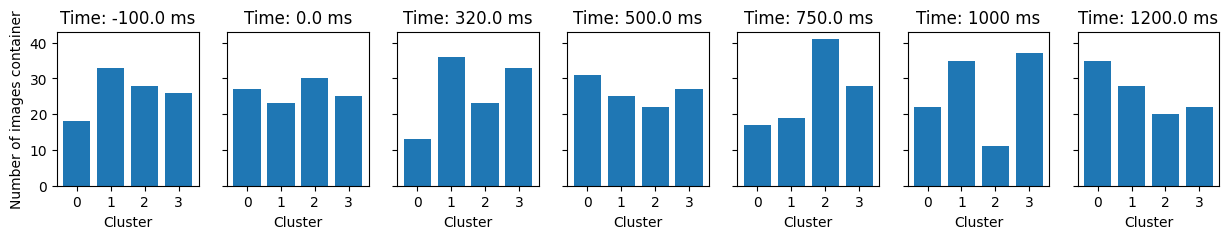

7it [00:00, 18.08it/s][00:05<00:17,  1.17it/s]


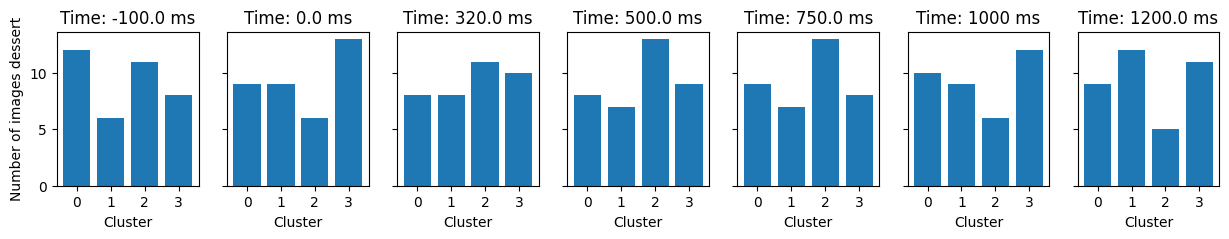

7it [00:00, 17.51it/s][00:06<00:15,  1.26it/s]


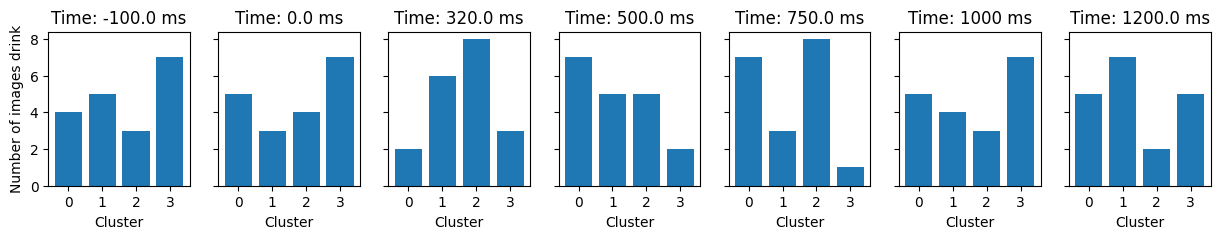

7it [00:00,  7.78it/s][00:07<00:15,  1.26it/s]


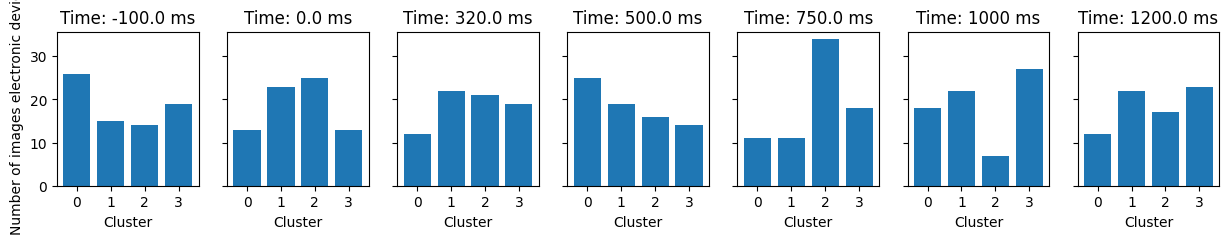

7it [00:00, 16.08it/s][00:08<00:19,  1.06s/it]


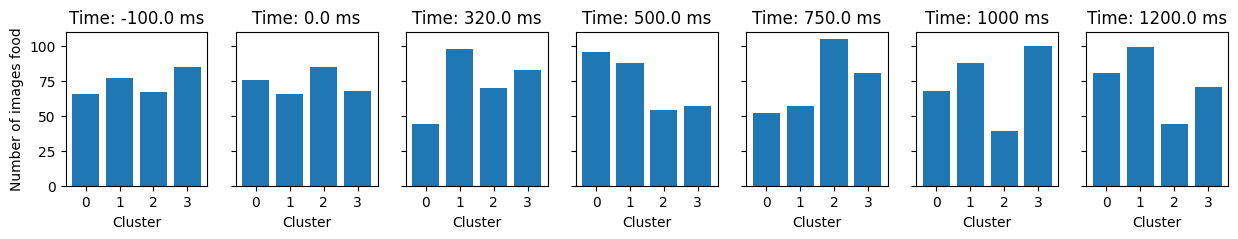

7it [00:00, 17.61it/s] [00:09<00:16,  1.03it/s]


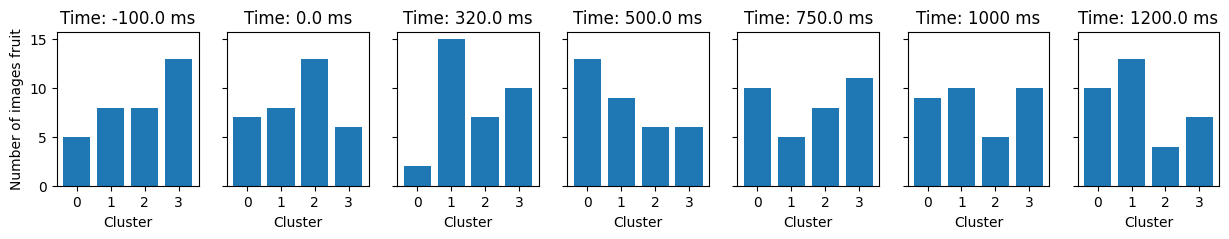

7it [00:00, 16.56it/s] [00:10<00:14,  1.09it/s]


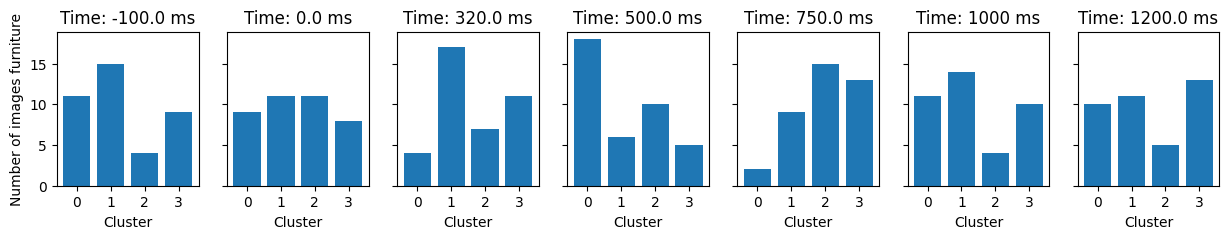

7it [00:00, 14.80it/s] [00:11<00:12,  1.17it/s]


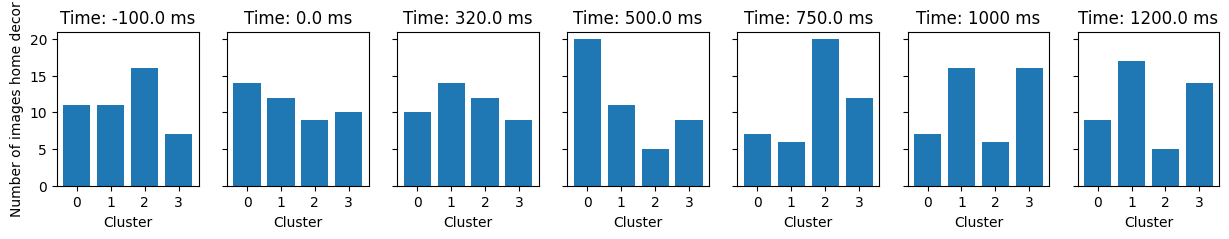

7it [00:00, 15.57it/s] [00:11<00:11,  1.21it/s]


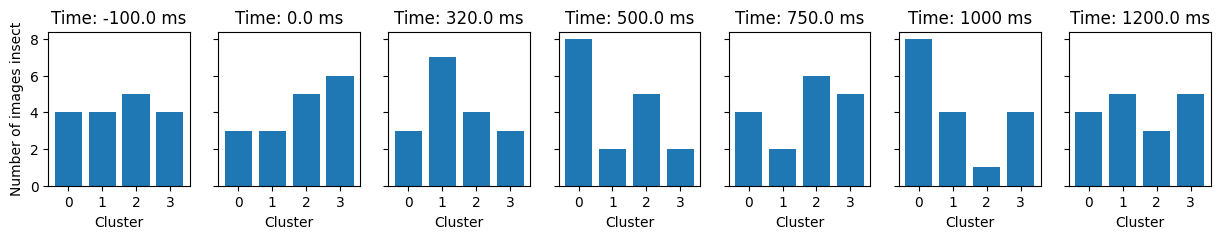

7it [00:00, 12.02it/s] [00:12<00:10,  1.23it/s]


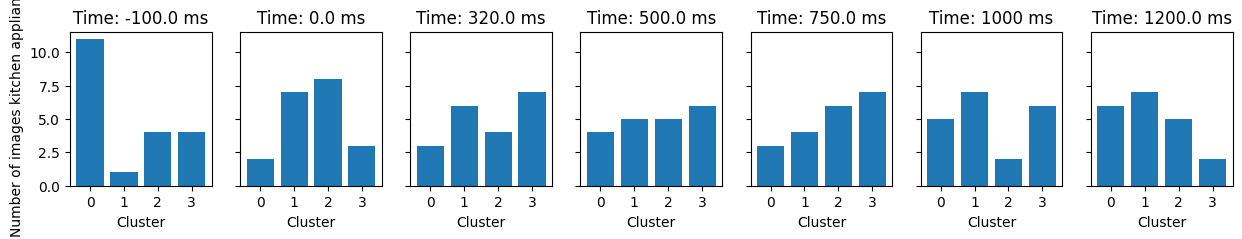

7it [00:00, 12.96it/s] [00:13<00:10,  1.19it/s]


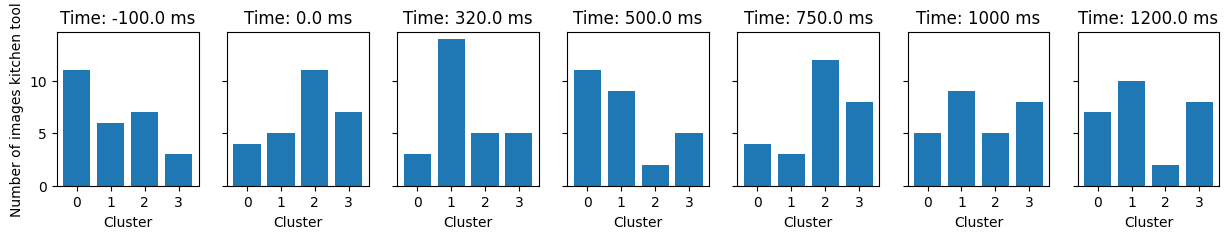

7it [00:00, 16.72it/s] [00:14<00:09,  1.19it/s]


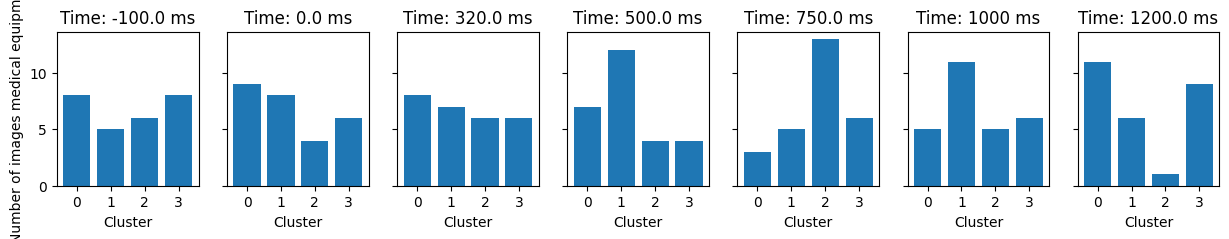

7it [00:00, 12.70it/s] [00:15<00:09,  1.05it/s]


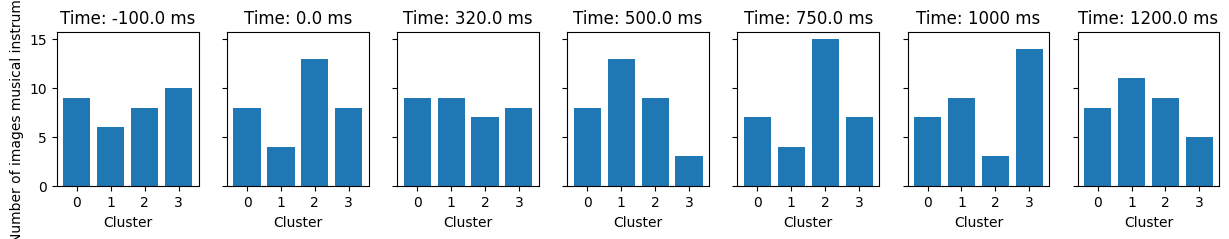

7it [00:00, 12.60it/s] [00:16<00:08,  1.05it/s]


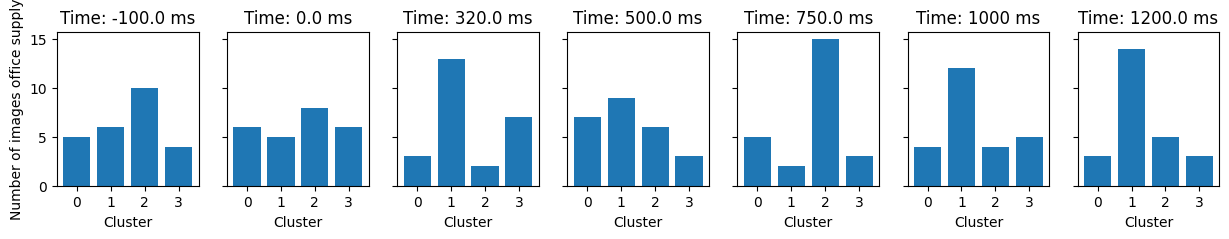

7it [00:00,  9.43it/s] [00:17<00:07,  1.05it/s]


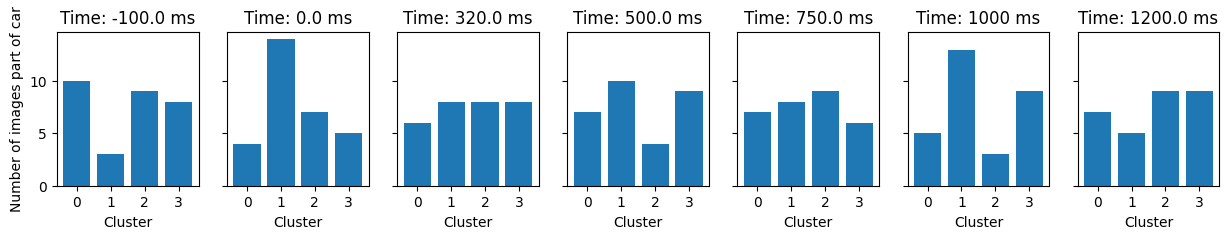

7it [00:00, 12.09it/s] [00:18<00:07,  1.00s/it]


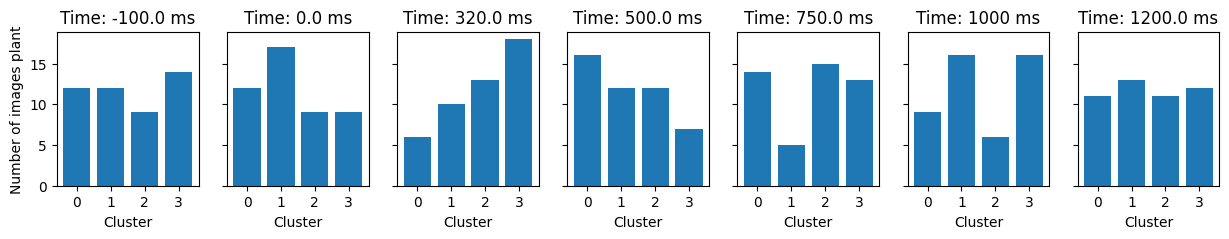

7it [00:00, 13.01it/s] [00:19<00:06,  1.00s/it]


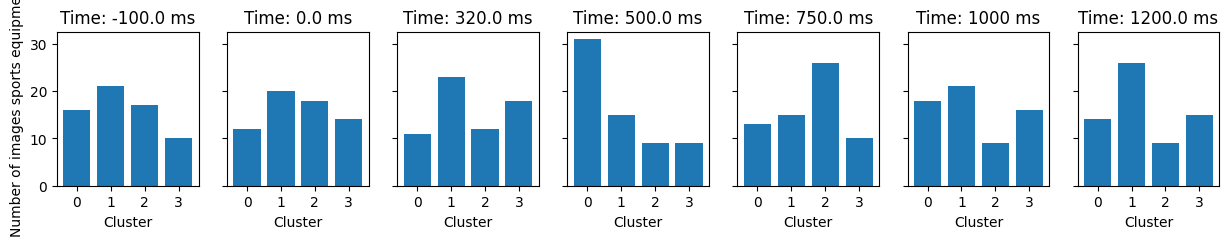

7it [00:00, 15.57it/s] [00:20<00:04,  1.04it/s]


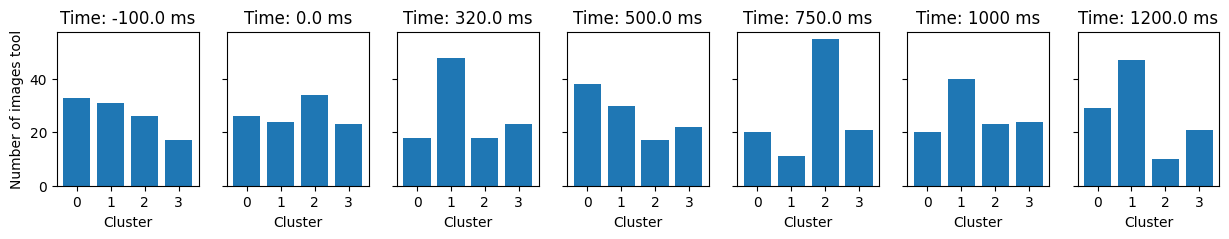

7it [00:00, 16.86it/s] [00:21<00:03,  1.12it/s]


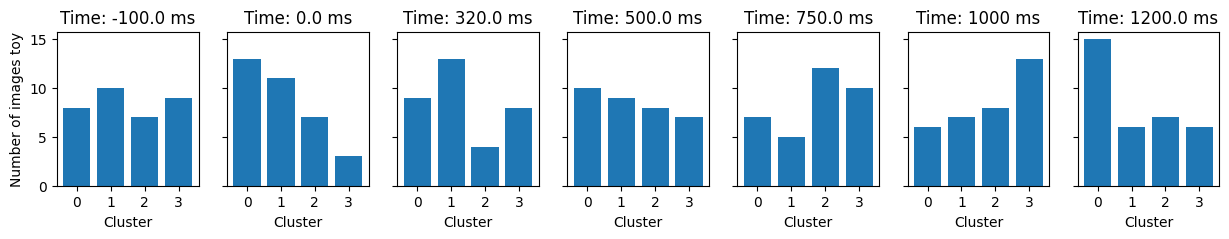

7it [00:00, 13.67it/s] [00:22<00:02,  1.14it/s]


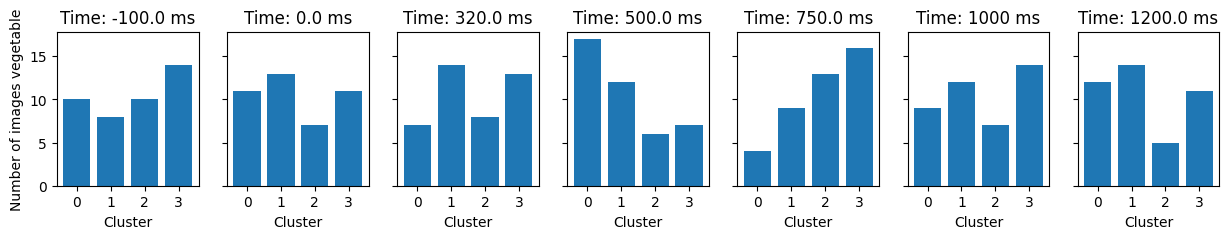

7it [00:00, 16.31it/s] [00:23<00:01,  1.02it/s]


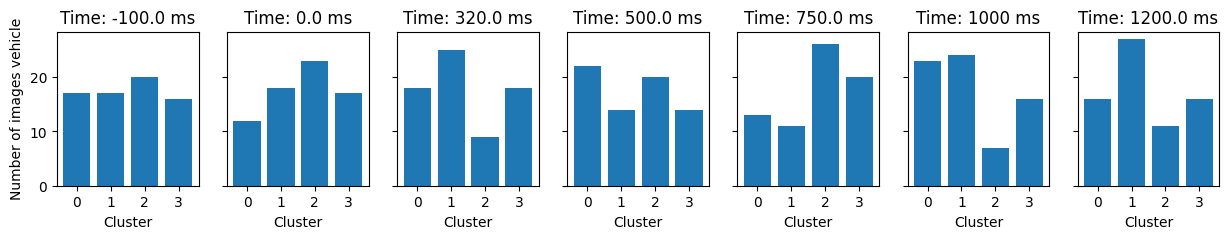

7it [00:00, 16.09it/s] [00:23<00:00,  1.11it/s]


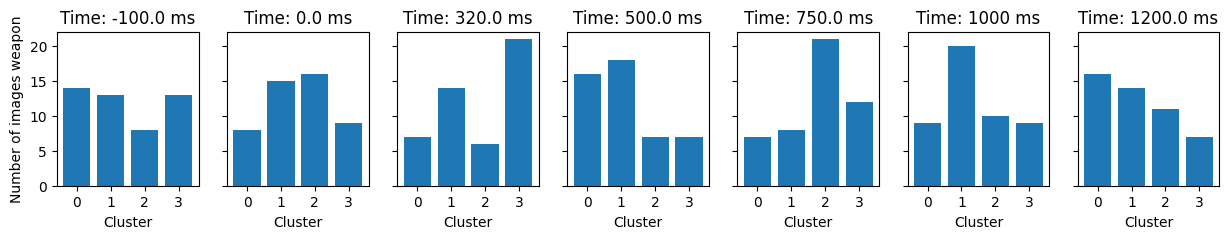

100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


In [45]:
from tqdm import tqdm    
category27 = pd.read_csv('category27_manual.tsv', sep='\t')
for category_name in tqdm(category27.columns):
    times = [-0.1,0.0, 0.320, 0.5, 0.75, 1, 1.2]
    # category_name = 'animal'
    f, axes = plt.subplots(1, len(times), sharex=True, sharey = True, figsize=(15, 2))   
    for i,t in tqdm(enumerate(times)):
        index = epochs.times == t
        data = average_concept_epochs[:, index, :].squeeze() 
        # print(data.shape)
        kmeans = KMeans(n_clusters=4, random_state=42).fit(data)
        labels = kmeans.labels_
        # # Get cluster centers
        centers = kmeans.cluster_centers_ 
        index_0 = np.where(labels == 0)[0]
        index_1 = np.where(labels == 1)[0]
        index_2 = np.where(labels == 2)[0]
        index_3 = np.where(labels == 3)[0]
        category = np.where(category27[category_name] == 1)[0]
        category_0 = len(np.intersect1d(category, index_0))
        category_1 = len(np.intersect1d(category, index_1))
        category_2 = len(np.intersect1d(category, index_2))
        category_3 = len(np.intersect1d(category, index_3)) 
    # #     # print(f"division of category: {category_0} vs {category_1}") 
        # plot these divisions are bar plot
        axes[i].bar(['0', '1', '2', '3'], [category_0, category_1, category_2, category_3])  
        axes[i].set_title(f"Time: {t*1000} ms")
        axes[0].set_ylabel(f'Number of images {category_name}')     
        axes[i].set_xlabel('Cluster')
    plt.show()  


## CLuster experiments end here